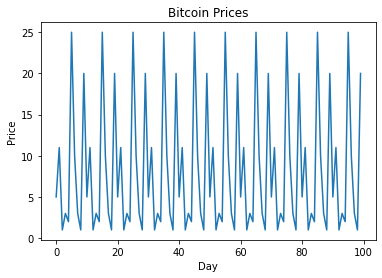

In [5]:
import os
import pyibl
import random
import numpy as np
import pandas as pd

eddies_path = '/Users/greywind/Desktop/Utep/Spring_2022/special_topics/python/project/bitcoin-ibl-model/scripts/data'

import matplotlib.pyplot as plt

from tqdm import tqdm

PARTICIPANTS = 100
ROUNDS = 100
NOISE = 0.25
DECAY = 0.5
DEFAULT_UTILITY = 30

BITCOIN_PRICES = [5, 11, 1, 3, 2, 25, 10, 3, 1, 20] * 10

plt.plot([day for day, _ in enumerate(BITCOIN_PRICES)], BITCOIN_PRICES)
plt.title('Bitcoin Prices')
plt.xlabel('Day')
plt.ylabel('Price')
plt.show()

100%|██████████| 100/100 [00:00<00:00, 103.16it/s]


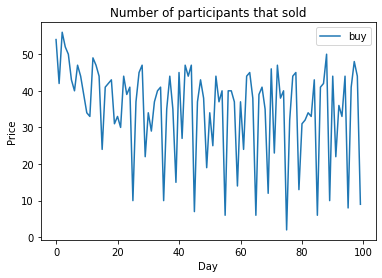

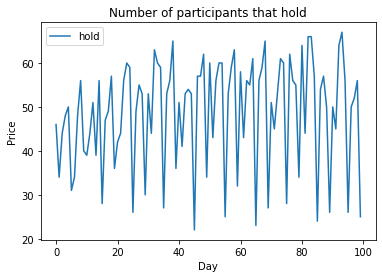

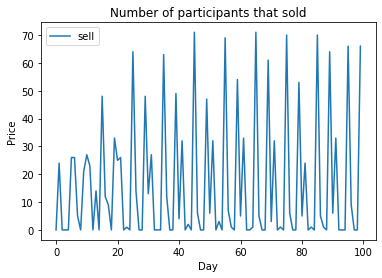

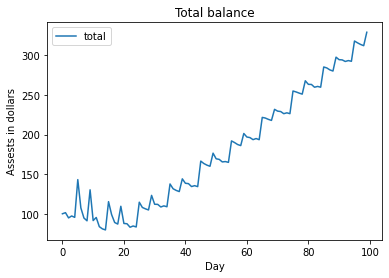

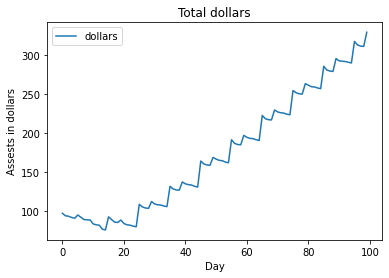

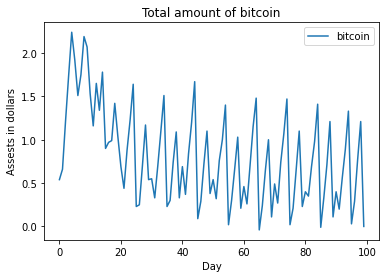

RUAN


In [10]:
def sim(x,y, max_of_bitcoin):
    return abs(x-y)/max_of_bitcoin


def run(bitcoin_prices, participants, directory="run/", file_name="data.csv", max_of_bitcoin=60000):
    agent = pyibl.Agent("Agent", ['action', 'price'], optimized_learning=False, default_utility=DEFAULT_UTILITY, noise=NOISE, decay=DECAY)
    pyibl.similarity(lambda x,y: sim(x,y,max_of_bitcoin), 'price')
    pyibl.mismatch_penalty = 2.5

    selects_buy  = np.zeros((participants, len(bitcoin_prices)))
    selects_sell = np.zeros((participants, len(bitcoin_prices)))
    selects_hold = np.zeros((participants, len(bitcoin_prices)))

    total_balance = np.zeros((participants, len(bitcoin_prices)))
    total_dollars = np.zeros((participants, len(bitcoin_prices)))
    total_bitcoin = np.zeros((participants, len(bitcoin_prices)))

    buy_prices = []
    for participant in tqdm(range(participants)):
        agent.reset()
        dollar_balance = 100
        bitcoin_balance = 0
        
        for day, price in enumerate(bitcoin_prices):
            choices = [
                {'action': 'hold', 'price': price},
            ]

            if dollar_balance >= 10:
                choices.append({'action': 'buy', 'price': price})
            
            # We can sell
            if bitcoin_balance * price >= 10 and len(buy_prices) != 0:
                choices.append({'action': 'sell', 'price': price})

            choice = agent.choose(*choices)

            if choice['action'] == 'buy':
                # One fault of the model is we have to set a default value to buy.
                buy_prices.append(price)
                selects_buy[participant][day] = 1
                agent.respond(0)
                dollar_balance -= price

                # We don't know how to change this number
                bitcoin_balance += 1
            if choice['action'] == 'sell':

                # They can only sell 10 dollars worth of bitcoin
                selects_sell[participant][day] = 1
                profit = price*len(buy_prices) - sum(buy_prices)
                buy_prices = []
                agent.respond(profit)
                dollar_balance += profit
                bitcoin_balance -= 10 / price

            if choice['action'] == 'hold':
                selects_hold[participant][day] = 1
                agent.respond(0)

            total_balance[participant][day] = dollar_balance + bitcoin_balance * price
            total_dollars[participant][day] = dollar_balance
            total_bitcoin[participant][day] = bitcoin_balance


    selects_buy = selects_buy.sum(axis=0)
    selects_sell = selects_sell.sum(axis=0)
    selects_hold = selects_hold.sum(axis=0)
    total_balance = total_balance.mean(axis=0)
    total_dollars = total_dollars.mean(axis=0)
    total_bitcoin = total_bitcoin.mean(axis=0)
    

    plt.plot([day for day, _ in enumerate(selects_buy)], selects_buy, label = "buy")
    plt.title('Number of participants that sold')
    plt.xlabel('Day')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

    plt.plot([day for day, _ in enumerate(selects_hold)], selects_hold, label = "hold")
    plt.title('Number of participants that hold')
    plt.xlabel('Day')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

    plt.plot([day for day, _ in enumerate(selects_sell)], selects_sell, label = "sell")
    plt.title('Number of participants that sold')
    plt.xlabel('Day')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

    plt.plot([day for day, _ in enumerate(total_balance)], total_balance, label='total')
    plt.title('Total balance')
    plt.xlabel('Day')
    plt.ylabel('Assests in dollars')
    plt.legend()
    plt.show()

    plt.plot([day for day, _ in enumerate(total_dollars)], total_dollars, label='dollars')
    plt.title('Total dollars')
    plt.xlabel('Day')
    plt.ylabel('Assests in dollars')
    plt.legend()
    plt.show()

    plt.plot([day for day, _ in enumerate(total_bitcoin)], total_bitcoin, label='bitcoin')
    plt.title('Total amount of bitcoin')
    plt.xlabel('Day')
    plt.ylabel('Assests in dollars')
    plt.legend()
    plt.show()


    # # Path 
    # path = os.path.join(eddies_path, directory)
    # os.mkdir(path)

    data = {
        'Total Balance':total_balance,
        'Total Dollars':total_dollars,
        'Total Bitcoin':total_bitcoin,
        'Selects Buy': selects_buy,
        'Selects Sell': selects_sell,
        'Selects Hold': selects_hold
    }

    df = pd.DataFrame(data)
    df.to_csv(file_name)


def main():
    run(BITCOIN_PRICES, PARTICIPANTS)

if __name__ == '__main__':
    main()

print("RUAN")